## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Activation

def build_mlp(input_shape, out_unit = 10, hidden_unit = [512, 256, 128], bn_before_act = 0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, unit_num in enumerate(hidden_unit):
        if i == 0:
            if bn_before_act == 0:
                x = keras.layers.Dense(units = unit_num, activation = 'relu', 
                                       name = 'hidden_'+str(i+1))(input_layer)
                x = BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units = unit_num, activation = 'linear', 
                                       name = 'hidden_'+str(i+1))(input_layer)
                x = BatchNormalization()(x)  
                x = Activation('relu')(x)
        else:
            if bn_before_act == 0:
                x = keras.layers.Dense(units = unit_num, activation = 'relu', 
                                       name = 'hidden_'+str(i+1))(x)
                x = BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units = unit_num, activation = 'linear', 
                                       name = 'hidden_'+str(i+1))(x)
                x = BatchNormalization()(x)  
                x = Activation('relu')(x)
    
    out_layer = keras.layers.Dense(out_unit, activation = 'softmax', name = 'output')(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [out_layer])    
    
    return model

In [8]:
"""Code Here
設定超參數
"""
EPOCHS = 50
BATCH_SIZE = [16, 32, 128, 256]
BN_BEFORE_ACT = [0, 1]

In [9]:
import itertools
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (bn_before, batchsize) in enumerate(itertools.product(BN_BEFORE_ACT, BATCH_SIZE)):
    print('test idx %d, BN_BE %d, BATCH_SIZE %d' % (i, bn_before, batchsize))
    keras.backend.clear_session()
    model = build_mlp(x_train.shape[1:], bn_before_act = bn_before)
    model.summary()
    
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    model.fit(x_train, y_train, epochs = EPOCHS,
              batch_size = batchsize,
              validation_data = (x_test, y_test), shuffle = True)

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    val_acc = model.history.history['val_acc']
    
    exp_tag = 'exp_%d_%d_%d' % (i, bn_before, batchsize)
    results[exp_tag] = {
        'train-loss': train_loss,
        'val-loss': val_loss,
        'train-acc': train_acc,
        'val-acc': val_acc
    }    


test idx 0, BN_BE 0, BATCH_SIZE 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_3 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

50000/50000 [==============================] - 98s 2ms/step - loss: 1.1832 - acc: 0.5802 - val_loss: 1.3839 - val_acc: 0.5110
Epoch 50/50
50000/50000 [==============================] - 98s 2ms/step - loss: 1.1850 - acc: 0.5786 - val_loss: 1.4008 - val_acc: 0.5187
test idx 1, BN_BE 0, BATCH_SIZE 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256) 

Epoch 48/50
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8638 - acc: 0.6924 - val_loss: 1.4529 - val_acc: 0.5233
Epoch 49/50
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8604 - acc: 0.6918 - val_loss: 1.5083 - val_acc: 0.5113
Epoch 50/50
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8574 - acc: 0.6912 - val_loss: 1.4935 - val_acc: 0.5173
test idx 2, BN_BE 0, BATCH_SIZE 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_2 (Dense)      

Epoch 46/50
50000/50000 [==============================] - 22s 448us/step - loss: 0.4199 - acc: 0.8483 - val_loss: 2.3804 - val_acc: 0.4692
Epoch 47/50
50000/50000 [==============================] - 22s 443us/step - loss: 0.4159 - acc: 0.8484 - val_loss: 2.2179 - val_acc: 0.4899
Epoch 48/50
50000/50000 [==============================] - 21s 417us/step - loss: 0.4074 - acc: 0.8532 - val_loss: 2.4051 - val_acc: 0.4689
Epoch 49/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.3901 - acc: 0.8590 - val_loss: 2.4294 - val_acc: 0.4792
Epoch 50/50
50000/50000 [==============================] - 18s 357us/step - loss: 0.3916 - acc: 0.8575 - val_loss: 2.2460 - val_acc: 0.5014
test idx 3, BN_BE 0, BATCH_SIZE 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________


Epoch 44/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.2893 - acc: 0.8976 - val_loss: 2.6582 - val_acc: 0.4776
Epoch 45/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.2780 - acc: 0.9017 - val_loss: 2.5885 - val_acc: 0.4826
Epoch 46/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.2785 - acc: 0.9028 - val_loss: 2.6209 - val_acc: 0.4768
Epoch 47/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.2858 - acc: 0.8964 - val_loss: 2.7206 - val_acc: 0.4728
Epoch 48/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.2593 - acc: 0.9076 - val_loss: 2.6467 - val_acc: 0.4874
Epoch 49/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.2520 - acc: 0.9108 - val_loss: 2.8158 - val_acc: 0.4639
Epoch 50/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.2416 - acc: 0.9142 - val_loss: 2.8519 - val_acc: 0.4787
test idx 4, BN_BE 1,

50000/50000 [==============================] - 100s 2ms/step - loss: 0.5624 - acc: 0.8010 - val_loss: 1.6902 - val_acc: 0.5289
Epoch 40/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.5607 - acc: 0.8011 - val_loss: 1.8208 - val_acc: 0.5080
Epoch 41/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.5509 - acc: 0.8048 - val_loss: 1.6806 - val_acc: 0.5237
Epoch 42/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.5366 - acc: 0.8088 - val_loss: 1.6378 - val_acc: 0.5513
Epoch 43/50
50000/50000 [==============================] - 99s 2ms/step - loss: 0.5265 - acc: 0.8137 - val_loss: 1.8174 - val_acc: 0.5284
Epoch 44/50
50000/50000 [==============================] - 109s 2ms/step - loss: 0.5186 - acc: 0.8163 - val_loss: 1.7775 - val_acc: 0.5175
Epoch 45/50
50000/50000 [==============================] - 110s 2ms/step - loss: 0.5163 - acc: 0.8185 - val_loss: 1.7968 - val_acc: 0.5162
Epoch 46/50
50000/50000 [=================

50000/50000 [==============================] - 51s 1ms/step - loss: 0.3449 - acc: 0.8793 - val_loss: 2.1926 - val_acc: 0.5110
Epoch 35/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3285 - acc: 0.8831 - val_loss: 2.5577 - val_acc: 0.4755
Epoch 36/50
50000/50000 [==============================] - 51s 1ms/step - loss: 0.3318 - acc: 0.8811 - val_loss: 2.2628 - val_acc: 0.5124
Epoch 37/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3185 - acc: 0.8871 - val_loss: 2.3791 - val_acc: 0.4941
Epoch 38/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3112 - acc: 0.8899 - val_loss: 2.5403 - val_acc: 0.4879
Epoch 39/50
50000/50000 [==============================] - 53s 1ms/step - loss: 0.3036 - acc: 0.8920 - val_loss: 3.0630 - val_acc: 0.4378
Epoch 40/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2977 - acc: 0.8950 - val_loss: 2.6822 - val_acc: 0.4686
Epoch 41/50
50000/50000 [=====================

50000/50000 [==============================] - 16s 323us/step - loss: 0.1589 - acc: 0.9448 - val_loss: 3.1276 - val_acc: 0.4727
Epoch 30/50
50000/50000 [==============================] - 16s 326us/step - loss: 0.1665 - acc: 0.9403 - val_loss: 3.1660 - val_acc: 0.4600
Epoch 31/50
50000/50000 [==============================] - 16s 323us/step - loss: 0.1608 - acc: 0.9437 - val_loss: 3.1507 - val_acc: 0.4769
Epoch 32/50
50000/50000 [==============================] - 16s 323us/step - loss: 0.1389 - acc: 0.9510 - val_loss: 3.1310 - val_acc: 0.4877
Epoch 33/50
50000/50000 [==============================] - 16s 323us/step - loss: 0.1403 - acc: 0.9518 - val_loss: 3.3671 - val_acc: 0.4650
Epoch 34/50
50000/50000 [==============================] - 16s 320us/step - loss: 0.1420 - acc: 0.9502 - val_loss: 3.0240 - val_acc: 0.4712
Epoch 35/50
50000/50000 [==============================] - 16s 324us/step - loss: 0.1374 - acc: 0.9513 - val_loss: 3.2589 - val_acc: 0.4567
Epoch 36/50
50000/50000 [=======

50000/50000 [==============================] - 10s 204us/step - loss: 0.1691 - acc: 0.9429 - val_loss: 2.8040 - val_acc: 0.4586
Epoch 25/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.1584 - acc: 0.9457 - val_loss: 3.1236 - val_acc: 0.4340
Epoch 26/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.1643 - acc: 0.9435 - val_loss: 2.8024 - val_acc: 0.4763
Epoch 27/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.1306 - acc: 0.9558 - val_loss: 2.8592 - val_acc: 0.4771
Epoch 28/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.1281 - acc: 0.9564 - val_loss: 3.0166 - val_acc: 0.4672
Epoch 29/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.1323 - acc: 0.9545 - val_loss: 3.0721 - val_acc: 0.4641
Epoch 30/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.1320 - acc: 0.9552 - val_loss: 3.4931 - val_acc: 0.4482
Epoch 31/50
50000/50000 [=======

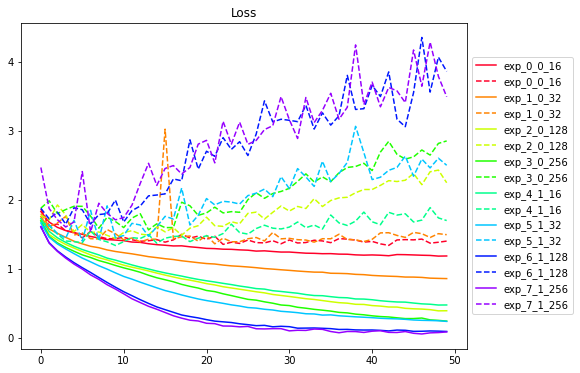

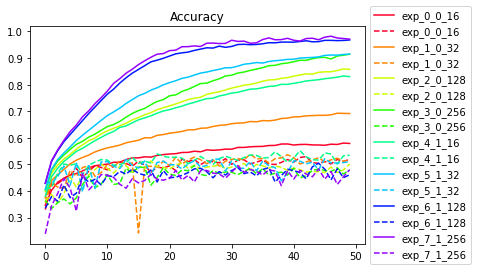

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_num = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_map = [cm(1.*i/color_num) for i in range(color_num)]

plt.figure(figsize = (8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label = cond, color = color_map[i])
    plt.plot(range(len(results[cond]['val-loss'])), results[cond]['val-loss'], '--', label = cond, color = color_map[i])
plt.title('Loss')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label = cond, color = color_map[i])
    plt.plot(range(len(results[cond]['val-acc'])), results[cond]['val-acc'], '--', label = cond, color = color_map[i])
plt.title('Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()
